In [1]:
import xarray as xr
import os, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
module_path = '/home/jupyter-ayoub'
if module_path not in sys.path:
    sys.path.append(module_path)
from Transformer import StackedTransformer

In [3]:
#ssrd6
test_rfcs=xr.open_dataset("/home/jupyter-ayoub/data/test/test_reforecast.nc")
obs=xr.open_dataset("/home/jupyter-ayoub/data/test/test_observation.nc")

In [4]:
test_rfcs=test_rfcs
obs=obs

In [5]:
target='ssrd6_obs'  
obs=obs[target]
test_rfcs=test_rfcs.drop_vars(['sd', 'mx2t6', 'mn2t6', 'q', 'ssr6', 'str6'])
#test_rfcs=test_rfcs.drop_vars(['t2m', 'z', 't', 'u10', 'v10', 'tcc', 'sd', 'mx2t6', 'mn2t6', 'w10', 'u100', 'w100', 'u', 'w700', 'p10fg6', 'v100', 'v', 'q', 'tp6', 'ssr6', 'str6', 'strd6'])
#test_rfcs=test_rfcs.drop_vars(['u10', 'v10', 'sd', 'mx2t6', 'mn2t6', 'w10', 'u100', 'w100', 'u', 'w700', 'p10fg6', 'v100', 'v', 'q', 'ssr6', 'str6']) #8
#[ 'sd', 'mx2t6', 'mn2t6', 'q', 'ssr6', 'str6']
#['sd', 'mx2t6', 'mn2t6', 'q', 'tp6', 'ssr6', 'str6', 'ssrd6', 'strd6']

In [6]:
print(obs.shape)

(209, 1, 20, 1, 32, 33)


In [7]:
#add orography as a variable
oro=xr.open_dataset("/home/jupyter-aaron/Postprocessing/PP_EUPP/data/oro.nc") 
dims={'time' : test_rfcs['time'],
       'number': test_rfcs['number'],
       'step': test_rfcs['step']}
xds_oro=oro.expand_dims(time=dims['time'], number=dims['number'],step=dims['step'])
dummy_oro=xr.Dataset(coords=dims)
final_oro=xds_oro.broadcast_like(dummy_oro)

In [8]:
fcs_10=xr.merge([test_rfcs,final_oro])
dummy=xr.merge([test_rfcs,final_oro])

In [9]:
#normalizing met oro.nc
min_max_values={"t2m":(235, 304), "z": (48200, 58000), "t":(240, 299), "u10": (-13., 11.),"v10": (-30,35), "tcc": (0., 1.0),"sd":(0,8),"mx2t6":(230,320),"mn2t6":(225,315),"v":(-50,55), "w100":(0,50),"w10":(0,30), "u100": (-35,45), "u": (-45,60),"v100":(-40,45), "w700": (0,60), "p10fg6": (0,60), "oro":(-400,2800),"ssr6":(0,3200000),"ssrd6":(-5200.0,18541902.0),"strd6":(2103856,9537712),"tp6":(-4,1),"ssr6":(-4220.0,15344816.0),"str6":(-4630656.0,1093968.0)}
# Function to normalize using vectorized operations
def minmax_normalize(ds, min_max_values):
    for var in ds.data_vars:
        if var in min_max_values:
            min_val, max_val = min_max_values[var]
            ds[var] = (ds[var] - min_val) / (max_val - min_val)
    return ds

def z_normalize(ds):
    for var in ds.data_vars:
        ds[var] = ds[var].copy()  # Ensure the variable is writable
        
        for t in range(len(ds["time"])):  # Loop over time dimension
            mean = ds[var].isel(time=t).mean()
            std = ds[var].isel(time=t).std()
            ds[var].loc[dict(time=ds["time"][t])] = (ds[var].isel(time=t) - mean) / std

    return ds



dummy_norm=minmax_normalize(dummy,min_max_values)
fcs_norm=dummy_norm

In [10]:
%reload_ext autoreload
model =  StackedTransformer(num_blocks=4, n_data_shape=(20, 32, 33, 18), n_heads=8,mlp_mult=4,projection_channels=64)

In [11]:
#this is where the last run is stored 
checkpoint_path = '/home/jupyter-ayoub/results/Transformerweights/ssrd6/Beste_result/epochs50predictors18CRPSKERNELSTEPlambda0.02k3.3.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, weights_only=False)
model_state_dict = checkpoint['model']
new_state_dict = {k.replace("module.", ""): v for k, v in model_state_dict.items()}
model.load_state_dict(new_state_dict)
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  1552161


In [12]:
#turn the normalized reforecasts into a tensor
fcs_norm_whole= fcs_norm.to_array(dim='variable')
print(fcs_norm_whole.sizes)
#print(fcs_norm_whole)
print(fcs_norm_whole.shape)
rearranged_10= fcs_norm_whole.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')
fcs_whole_tensor=torch.tensor(rearranged_10.values)
print(fcs_whole_tensor.shape) 

Frozen({'variable': 18, 'time': 209, 'number': 11, 'step': 20, 'latitude': 32, 'longitude': 33})
(18, 209, 11, 20, 32, 33)
torch.Size([209, 11, 20, 32, 33, 18])


In [13]:
#same for unnormalized data, because I need them for the rescaling 
fcs_array_10 =fcs_10.to_array(dim='variable')
fcs_rearranged_10= fcs_array_10.transpose('time', 'number','step', 'latitude', 'longitude', 'variable')
fcs_whole_notnorm_tensor=torch.tensor(fcs_rearranged_10.values)
print(fcs_whole_notnorm_tensor.shape)

torch.Size([209, 11, 20, 32, 33, 18])


In [14]:
MBM_one=np.empty((209,11,20,32,33),dtype=float)
for i in range(20):
    mbm1=np.load(f"/home/jupyter-ayoub/ClassicalMBM/resultsClassicalMBM/{target}/MBM_{target}_{i}.npy")
    MBM_one[:,:,i,:,:]=mbm1.squeeze()

In [15]:
postpro_10_whole = torch.empty((209,11,20,32,33,1))

# Apply model in chunks of 10
with torch.no_grad():
    for i in range(0, 209, 2):
        # Get the end index for this chunk
        end = min(i + 2, 209)  # Ensure we don't go out of bounds

        # Apply the model to the chunk and store in the corresponding location in postpro_10_whole
        #print(fcs_whole_tensor[i:end].shape)
        #print(postpro_10_whole[i:end].shape)
        postpro_10_whole[i:end] = model(fcs_whole_tensor[i:end])

In [16]:
# Extract ensemble forecasts
ensemble_one = postpro_10_whole[...,0]

# Compute standard deviation & mean across ensemble dimension (dim=1)
scale_std, scale_mean = torch.std_mean(fcs_whole_notnorm_tensor[..., 15], dim=1, unbiased=True)

# Function to scale and clamp ensemble data
def scale_and_clamp(ensemble):
    scaled = ensemble * scale_std.unsqueeze(1) + scale_mean.unsqueeze(1)
    return torch.clamp(scaled, min=1e-6).permute(1, 0, 2, 3, 4)

# Apply scaling and clamping
scaled_ensemble_one = scale_and_clamp(ensemble_one)

In [17]:
# Define coordinates with member first
coords_forecast = {
    'member': test_rfcs['number'].rename({'number': 'member'}),
    'time': obs['time'],
    'step': obs['step'],
    'latitude': obs['latitude'],
    'longitude': obs['longitude'],
}


# Define dimensions with member first
dims_forecast = ('member', 'time', 'step', 'latitude', 'longitude')

# Convert numpy arrays to xarray DataArray with the specified order
MBM_one=xr.DataArray(np.transpose(MBM_one,(1,0,2,3,4)), coords=coords_forecast, dims=dims_forecast)
full_ensemble_one= xr.DataArray(scaled_ensemble_one, coords=coords_forecast, dims=dims_forecast)

# Compute mean and std across the member dimension
mean_one = full_ensemble_one.mean(dim='member')
std_one = full_ensemble_one.std(dim='member')

# Adjust raw_fcs to have 'member' first
raw_fcs = test_rfcs.rename({'number': 'member'})
raw_fcs = raw_fcs.transpose('member', 'time', 'step', 'latitude', 'longitude')
raw_mean=raw_fcs.mean(dim='member')
raw_std=raw_fcs.std(dim='member')

In [18]:
#ALL ENSEMBLES
Tformer_one=full_ensemble_one
MBM_one = MBM_one
Raw = raw_fcs['ssrd6']
obs=obs.squeeze()

In [20]:
sv_obs=obs

In [ ]:
# Opslaan
np.save("/home/jupyter-ayoub/results/energie/ssrd6/Tformer_one.npy", Tformer_one)
np.save("/home/jupyter-ayoub/results/energie/ssrd6/MBM_one.npy", MBM_one)
np.save("/home/jupyter-ayoub/results/energie/ssrd6/Raw_ssrd6.npy", Raw)
np.save("/home/jupyter-ayoub/results/energie/ssrd6/obs.npy", obs)

In [ ]:
Tformer_one = np.load("/home/jupyter-ayoub/results/energie/ssrd6/Tformer_one.npy")
MBM_one = np.load("/home/jupyter-ayoub/results/energie/ssrd6/MBM_one.npy")
Raw = np.load("/home/jupyter-ayoub/results/energie/ssrd6/Raw_ssrd6.npy")
sv_obs = np.load("/home/jupyter-ayoub/results/energie/ssrd6/obs.npy")

In [21]:
import torch

def solar_irradiance_to_power(ghi_tensor: torch.Tensor, eta_pv: float = 0.18, area_pv: float = 1.0) -> torch.Tensor:
    """
    De paper "Current-Day and Future Dunkelflaute Risks for Belgium", in Section 2 
    "Solar power is computed from GHI data by assuming a fixed conversion efficiency of 18% for the installed PV capacity. 
    The efficiency is applied directly to the GHI to estimate solar power generation."
    
    
    Zet globale horizontale instraling (GHI) om naar opgewekt vermogen van een PV-systeem.
    
    Parameters:
    - ghi_tensor (torch.Tensor): Tensor met GHI-waarden in W/m².
    - eta_pv (float): Rendement van het PV-systeem (standaard 0.18 voor 18%).
    - area_pv (float): Oppervlakte van het PV-systeem in m² (standaard 1.0 m²).
    
    Returns:
    - torch.Tensor: Tensor met opgewekt vermogen in Watt.
    """
    return eta_pv * area_pv * ghi_tensor


In [22]:
solar_power_output_tf = solar_irradiance_to_power(
    Tformer_one /21600 # convert from J/m² to W/m²
)
solar_power_output_mbm = solar_irradiance_to_power(
    MBM_one /21600 # convert from J/m² to W/m²
)
solar_power_output_raw = solar_irradiance_to_power(
    Raw /21600 # convert from J/m² to W/m²
)
solar_power_output_obs = solar_irradiance_to_power(
    sv_obs /21600 # convert from J/m² to W/m²
)

In [ ]:
print(solar_power_output_obs.shape)

In [ ]:
print(solar_power_output_tf.shape,solar_power_output_mbm.shape,solar_power_output_raw.shape)

In [ ]:
solar_energy_kWh = solar_power_output * 6 / 1000  # W × h → Wh → kWh

In [ ]:
# Som over alle gridpoints en ensembleleden → totaal vermogen per tijd
total_power_per_time = solar_power_output.sum(axis=(0, 2, 3))  # shape: (time,)

In [ ]:
mean_power_per_time = solar_power_output.mean(axis=0).sum(axis=(1, 2))  # shape: (time,)

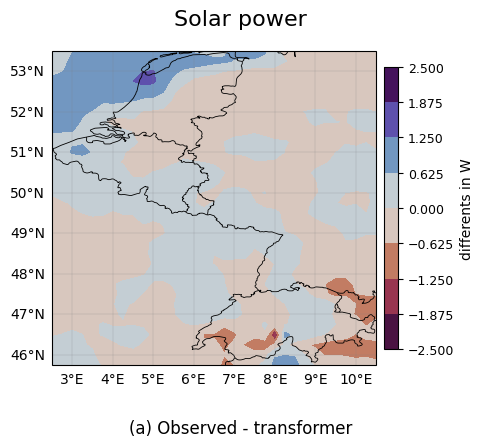

In [26]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = obs.longitude.values  # of .lon
lats = obs.latitude.values

TF_1 = solar_power_output_tf.mean(axis=0).mean(axis=(0, 1))
OBS_1 = solar_power_output_obs.mean(axis=(0, 1))

#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/w100/Raw_fair_crps.npy")
# Data voorbereidenS
diff =  OBS_1 - TF_1

# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

levels = np.linspace(-2.5, 2.5, 9)
# Contourplot met nette levels
cf = ax.contourf(lon2d, lat2d,diff, cmap='twilight_shifted_r',transform=ccrs.PlateCarree(),levels=levels, )

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.9, aspect=20)
cbar.set_label(r'differents in W', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot

plt.suptitle('Solar power', fontsize=16,ha='center')
plt.figtext(0.5, -0.08, r"(a) Observed - transformer", fontsize=12, ha='center')
plt.tight_layout()
plt.savefig("/home/jupyter-ayoub/Pictures/ssrd6/power_map_obs-transformer.png", bbox_inches='tight')
plt.show()

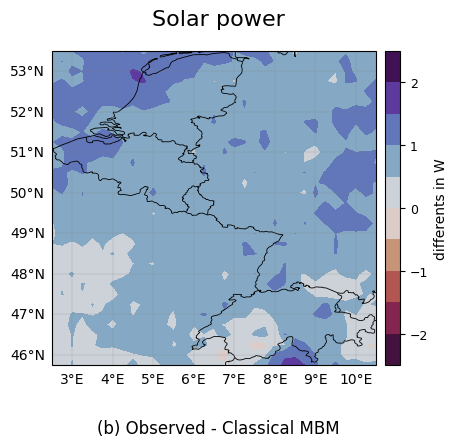

In [25]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = obs.longitude.values  # of .lon
lats = obs.latitude.values

MBM_1 = solar_power_output_mbm.mean(axis=0).mean(axis=(0, 1))
OBS_1 = solar_power_output_obs.mean(axis=(0, 1))

#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/w100/Raw_fair_crps.npy")
# Data voorbereidenS
diff =  OBS_1 - MBM_1

# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

levels = np.linspace(-2.5, 2.5, 11)
# Contourplot met nette levels
cf = ax.contourf(lon2d, lat2d,diff, cmap='twilight_shifted_r',transform=ccrs.PlateCarree(),levels=levels, )

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.set_label(r'differents in W', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.suptitle('Solar power', fontsize=16,ha='center')
plt.figtext(0.5, -0.08, r"(b) Observed - Classical MBM", fontsize=12, ha='center')
plt.tight_layout()
plt.savefig("/home/jupyter-ayoub/Pictures/ssrd6/power_map_obs-mbm_11.png", bbox_inches='tight')
plt.show()

In [ ]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = obs.longitude.values  # of .lon
lats = obs.latitude.values

RAW_ssrd6_1 = solar_power_output_raw.mean(axis=0).mean(axis=(0, 1))
OBS_1 = solar_power_output_obs.mean(axis=(0, 1))

#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/w100/Raw_fair_crps.npy")
# Data voorbereidenS
diff =  OBS_1 - RAW_ssrd6_1

# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

levels = np.linspace(-2.5, 2.5, 10)
# Contourplot met nette levels
cf = ax.contourf(lon2d, lat2d,diff, cmap='twilight_shifted_r',transform=ccrs.PlateCarree(),levels=levels, )

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, aspect=20)
cbar.set_label(r'differents in W', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.suptitle('Solar power', fontsize=16,ha='center')
plt.figtext(0.5, -0.08, r"(c) Observed - RAW", fontsize=12, ha='center')
plt.tight_layout()
plt.savefig("/home/jupyter-ayoub/Pictures/ssrd6/power_map_obs-raw_10.png", bbox_inches='tight')
plt.show()

In [ ]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = obs.longitude.values  # of .lon
lats = obs.latitude.values

TF_1 = solar_power_output_tf.mean(axis=0).mean(axis=(0, 1))
MBM_1 = solar_power_output_mbm.mean(axis=0).mean(axis=(0, 1))

#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/w100/Raw_fair_crps.npy")
# Data voorbereidenS
diff =  MBM_1 - TF_1

# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

# Contourplot met nette levels
levels = np.linspace(-2.5, 2.5, 10)
cf = ax.contourf(lon2d, lat2d, diff, cmap='twilight_shifted_r',transform=ccrs.PlateCarree(),levels=levels)

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.9, aspect=20)
cbar.set_label(r'differents in W', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.title('Solar power', fontsize=22)
plt.figtext(0.5, -0.08, r"(b) Classical MBM - Transformer", fontsize=12, ha='center')

plt.tight_layout()
plt.show()

In [ ]:
##### import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import TwoSlopeNorm

lons = obs.longitude.values  # of .lon
lats = obs.latitude.values

TF_1 = solar_power_output_tf.mean(axis=0).mean(axis=(0, 1))
OG = solar_power_output_raw.mean(axis=0).mean(axis=(0, 1))

#CRPS_OG=np.load("/home/jupyter-ayoub/results/CRPS/w100/Raw_fair_crps.npy")
# Data voorbereidenS
diff =  OG - TF_1

# Coördinaten grid voor contourplot
lon2d, lat2d = np.meshgrid(lons, lats)

# Plotfiguur
levels = np.linspace(-2.5, 2.5, 9)
fig, ax = plt.subplots(figsize=(5, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([2.5, 10.5, 45.75, 53.5], crs=ccrs.PlateCarree())

# Geografische lagen
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), linewidth=0.6)

# Contourplot met nette levels
cf = ax.contourf(lon2d, lat2d, diff, cmap='twilight_shifted_r',transform=ccrs.PlateCarree(),levels=levels)

# Nette colorbar met LaTeX label
cbar = fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, shrink=0.9, aspect=20)
cbar.set_label(r'differents in W', fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Geen titel in het plot zelf
ax.set_title("")

# Ondertitel buiten plot
plt.title('Solar power', fontsize=22)
plt.figtext(0.5, -0.08, r"(b) RAW - Transformer", fontsize=12, ha='center')

plt.tight_layout()
plt.show()

In [ ]:
def compute_ensemble_mae(forecast, observed, reduce_dims=True):
    """
    Bereken de MAE tussen ensemble voorspellingen en observaties.

    Parameters:
    -----------
    forecast : np.ndarray
        Voorspellingen met shape (member, time, step, lat, lon)
    observed : np.ndarray
        Observaties met shape (time, step, lat, lon)
    reduce_dims : bool
        Als True retourneert de functie de gemiddelde MAE (scalar),
        anders retourneert ze de MAE per gridpunt (time, step, lat, lon)

    Returns:
    --------
    mae : float of np.ndarray
        De Mean Absolute Error tussen forecast en observed
    """
    # Zorg dat forecast en observed numpy arrays zijn
    forecast = np.asarray(forecast)
    observed = np.asarray(observed)

    # Neem gemiddelde over de ensembleleden (dim 0)
    forecast_mean = forecast.mean(axis=0)  # shape = (time, step, lat, lon)

    # Bereken absolute fout
    abs_error = np.abs(forecast_mean - observed)  # shape = (time, step, lat, lon)

    if reduce_dims:
        # Neem gemiddelde over alle dimensies → scalar MAE
        return abs_error.mean()
    else:
        # Retourneer MAE per gridpunt
        return abs_error

In [ ]:
mae_tf = compute_ensemble_mae(Tformer_one, sv_obs)
mae_mbm = compute_ensemble_mae(MBM_one, sv_obs)
mae_raw = compute_ensemble_mae(Raw, sv_obs)
print(mae_tf,mae_mbm,mae_raw)

In [ ]:
mae_per_point_tf = compute_ensemble_mae(Tformer_one, sv_obs, reduce_dims=False)
mae_mean_tf = mae_per_point_tf.mean(axis=0).mean(axis=(1, 2))
mae_per_point_mbm = compute_ensemble_mae(MBM_one, sv_obs, reduce_dims=False)
mae_mean_mbm = mae_per_point_mbm.mean(axis=0).mean(axis=(1, 2))
mae_per_point_raw = compute_ensemble_mae(Raw, sv_obs, reduce_dims=False)
mae_mean_raw = mae_per_point_raw.mean(axis=0).mean(axis=(1, 2))

In [ ]:
print(obs.sizes)

In [ ]:
Leadtimes=obs.step.values
matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(10, 9))
plt.plot(Leadtimes, mae_mean_tf, color='red', marker='o', label='Postprocessed, transformer')
plt.plot(Leadtimes, mae_mean_mbm, color='blue', marker='*', label='Postprocessed, classical mbm')
plt.plot(Leadtimes, mae_mean_raw, color='green', marker='x', label='raw forcast')

plt.axhline(y=mae_tf, color='RED',linestyle=':')
plt.axhline(y=mae_mbm, color='BLUE',linestyle=':')
plt.axhline(y=mae_raw, color='GREEN',linestyle=':')


# Set title and labels
plt.title('Mean Absolute Error per lead time (solar radiation)', fontsize=22)
plt.xlabel('Forecast lead time [hours]', fontsize=18)
plt.ylabel('[J/m$^2$]', fontsize=18)

# Set y-axis limits and x-axis ticks
#plt.xlim(0,123)
plt.ylim(0,1400000)
# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)
# Ondertitel buiten plot
# Adjust layout and show the plot

plt.tight_layout()
plt.savefig("/home/jupyter-ayoub/Pictures/ssrd6/MAE_leadtime.png", bbox_inches='tight')
plt.show()

In [ ]:
Leadtimes=obs.step.values
matplotlib.rcParams['text.usetex'] = False
plt.figure(figsize=(10, 8))
plt.plot(Leadtimes, mae_mean, color='red', marker='o', label='Mean Absolute Error')


# Set title and labels
plt.title('Mean Absolute Error per lead time (solar radiation)', fontsize=22)
plt.xlabel('Forecast lead time [hours]', fontsize=18)
plt.ylabel('J/m$^2$', fontsize=18)

# Set y-axis limits and x-axis ticks
#plt.xlim(0,123)
#plt.ylim(0,70)

# Set tick label size and show legend
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)

# Adjust layout and show the plot
plt.tight_layout()
#plt.savefig("CRPS_leadtime_all.png")
plt.figtext(0.5, -0.08, r"(b) Classical MBM ", fontsize=18, ha='center')
plt.show()

In [ ]:
import numpy as np

def compute_bias(forecast, observed, reduce_dims=True):
    """
    Bereken bias tussen ensemble forecast en observatie.

    Parameters:
    -----------
    forecast : np.ndarray
        Ensemble voorspellingen van shape (member, time, step, lat, lon)
    observed : np.ndarray
        Observaties van shape (time, step, lat, lon)
    reduce_dims : bool
        Als True retourneer je gemiddelde bias per leadtime (shape = [step])
        Als False retourneer je volledige bias-array (shape = [time, step, lat, lon])

    Returns:
    --------
    bias : np.ndarray
        Bias per leadtime (of volledige array als reduce_dims=False)
    """
    # Neem ensemblegemiddelde: (time, step, lat, lon)
    forecast_mean = forecast.mean(axis=0)

    # Bereken bias (voorspelling - observatie)
    bias = forecast_mean - observed

    if reduce_dims:
        # Gemiddeld over tijd, lat, lon → bias per leadtime (step)
        return bias.mean(axis=(0, 2, 3))  # shape = (step,)
    else:
        return bias  # shape = (time, step, lat, lon)


In [ ]:
import matplotlib.pyplot as plt

# Bereken bias
bias_per_leadtime = compute_bias(Tformer_one, sv_obs)

# Laad leadtimes op (bijv. uit xarray)
Leadtimes = obs.step.values  # of np.arange(0, 120+6, 6)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Leadtimes, bias_per_leadtime, marker='o', color='blue', label='Bias')
plt.axhline(0, color='gray', linestyle='--')

plt.title('Gemiddelde bias per leadtime (ssrd6)', fontsize=16)
plt.xlabel('Lead time [hours]', fontsize=14)
plt.ylabel('Bias [J/m$^2$]', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.figtext(0.5, -0.08, r"(a) Transformer", fontsize=18, ha='center')
plt.savefig("/home/jupyter-ayoub/Pictures/ssrd6/bias-transformer.png",  bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Bereken bias
bias_per_leadtime = compute_bias(MBM_one, sv_obs)

# Laad leadtimes op (bijv. uit xarray)
Leadtimes = obs.step.values  # of np.arange(0, 120+6, 6)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Leadtimes, bias_per_leadtime, marker='o', color='blue', label='Bias')
plt.axhline(0, color='gray', linestyle='--')

plt.title('Gemiddelde bias per leadtime (ssrd6)', fontsize=16)
plt.xlabel('Lead time [hours]', fontsize=14)
plt.ylabel('Bias [J/m$^2$]', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.figtext(0.5, -0.08, r"(b) Classical MBM ", fontsize=18, ha='center')
plt.savefig("/home/jupyter-ayoub/Pictures/ssrd6/bias-mbm.png",  bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Bereken bias
bias_per_leadtime = compute_bias(Raw, sv_obs)

# Laad leadtimes op (bijv. uit xarray)
Leadtimes = obs.step.values  # of np.arange(0, 120+6, 6)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Leadtimes, bias_per_leadtime, marker='o', color='blue', label='Bias')
plt.axhline(0, color='gray', linestyle='--')

plt.title('Gemiddelde bias per leadtime (ssrd6)', fontsize=16)
plt.xlabel('Lead time [hours]', fontsize=14)
plt.ylabel('Bias [J/m$^2$]', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.figtext(0.5, -0.08, r"(C) RAW ", fontsize=18, ha='center')
plt.savefig("/home/jupyter-ayoub/Pictures/ssrd6/bias-raw.png",  bbox_inches='tight')
plt.show()